<a href="https://colab.research.google.com/github/Meenarekha/Computer-Vision/blob/main/Image_Classification_%26_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing class: animals
Loading image: D:\sem 4\AD23402(CV)\my_dataset\animals\panda.jpg
Loading image: D:\sem 4\AD23402(CV)\my_dataset\animals\tiger.jpg
Processing class: foods
Loading image: D:\sem 4\AD23402(CV)\my_dataset\foods\burger.jpg
Loading image: D:\sem 4\AD23402(CV)\my_dataset\foods\pizza.jpg
Processing class: nature
Loading image: D:\sem 4\AD23402(CV)\my_dataset\nature\beach.jpg
Loading image: D:\sem 4\AD23402(CV)\my_dataset\nature\mountain.jpg
Processing class: vehicles
Loading image: D:\sem 4\AD23402(CV)\my_dataset\vehicles\auto.jpg
Loading image: D:\sem 4\AD23402(CV)\my_dataset\vehicles\car.jpg
X shape: (8, 8356), y shape: (8,)
Training class distribution: {np.int64(0): np.int64(1), np.int64(1): np.int64(2), np.int64(2): np.int64(1), np.int64(3): np.int64(2)}


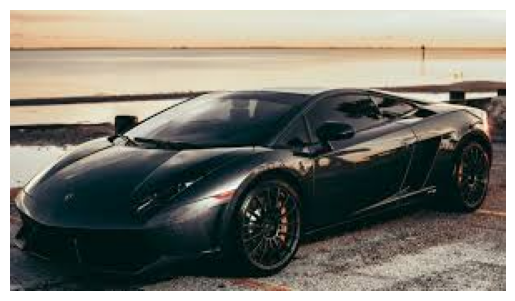

Predicted Class: vehicles


In [ ]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Path to your dataset (corrected with raw string)
dataset_path = r"D:\sem 4\AD23402(CV)\my_dataset"
classes = os.listdir(dataset_path)

# SIFT feature extraction
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))  # Return a zero vector if no descriptors
    return np.mean(descriptors, axis=0)  # Take the mean of descriptors to have fixed-length feature

# HOG feature extraction
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=True)
    return features

# GLOH feature extraction (mean of SIFT descriptors variance)
def extract_gloh_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))  # Return a zero vector if no descriptors
    return np.var(descriptors, axis=0)  # Return the variance of descriptors

# Debug: Check dataset structure and path
X, y = [], []
for label, flower in enumerate(classes):
    flower_path = os.path.join(dataset_path, flower)
    print(f"Processing class: {flower}")
    for img_name in os.listdir(flower_path):
        img_path = os.path.join(flower_path, img_name)
        print(f"Loading image: {img_path}")

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load {img_path}")
            continue

        image = cv2.resize(image, (128, 128))  # Resize image to a fixed size
        sift_feat = extract_sift_features(image)
        hog_feat = extract_hog_features(image)
        gloh_feat = extract_gloh_features(image)

        # Stack all features together
        features = np.hstack((sift_feat, hog_feat, gloh_feat))
        X.append(features)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Debug: Check feature shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Normalize features (Scaling)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training class distribution:", dict(zip(unique, counts)))

# Train RandomForestClassifier
clf = rf(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Function to classify new image
def classify_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize image to match the trained size

    sift_feat = extract_sift_features(image)
    hog_feat = extract_hog_features(image)
    gloh_feat = extract_gloh_features(image)

    # Stack features and reshape to match the model input
    features = np.hstack((sift_feat, hog_feat, gloh_feat)).reshape(1, -1)
    features = scaler.transform(features)  # Scale features

    # Predict class
    pred_label = clf.predict(features)[0]
    predicted_class = classes[pred_label]  # Convert predicted label to class name
    print(f"Predicted Class: {predicted_class}")

# Test with an image
test_image_path = r'D:\sem 4\AD23402(CV)\my_dataset\vehicles\car.jpg'
image = cv2.imread(test_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)
plt.show()  # Show image
classify_image(test_image_path)  # Classify the image


Number of estimated clusters: 7
Number of good matches: 14


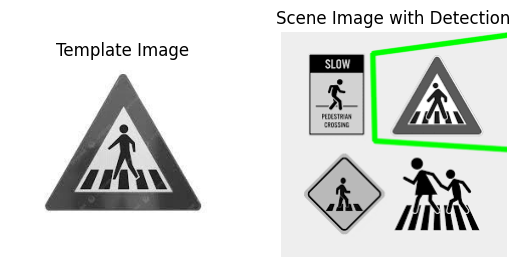

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Load images
template = cv2.imread(r'C:\Users\Meena\OneDrive\Pictures\template.jpg', cv2.IMREAD_GRAYSCALE)
scene = cv2.imread(r'C:\Users\Meena\OneDrive\Pictures\scene.png', cv2.IMREAD_GRAYSCALE)

# Use SIFT for keypoint detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(template, None)
kp2, des2 = sift.detectAndCompute(scene, None)

# Apply MeanShift clustering on keypoints of the scene image
x = np.array([kp.pt for kp in kp2])
bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(x)

# Extract cluster information
labels = ms.labels_
n_clusters = len(np.unique(labels))
print(f"Number of estimated clusters: {n_clusters}")

# Use FLANN-based matcher to find template in the scene
index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE = 1
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Convert descriptors to float32 for FLANN
des1 = np.float32(des1)
des2 = np.float32(des2)

matches = flann.knnMatch(des1, des2, k=2)

# Ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # Adjusted ratio for better accuracy
        good_matches.append(m)

print(f"Number of good matches: {len(good_matches)}")

# Proceed only if enough matches are found
if len(good_matches) > 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        h, w = template.shape
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, M)

        # Draw bounding box on detected region
        scene_color = cv2.cvtColor(scene, cv2.COLOR_GRAY2BGR)
        cv2.polylines(scene_color, [np.int32(transformed_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Show the result
        plt.subplot(121)
        plt.title('Template Image')
        plt.axis('off')
        plt.imshow(template, cmap='gray')

        plt.subplot(122)
        plt.title('Scene Image with Detection')
        plt.axis('off')
        plt.imshow(cv2.cvtColor(scene_color, cv2.COLOR_BGR2RGB))

        plt.show()
    else:
        print("Homography not found.")
else:
    print("Not enough matches found.")
